In [1]:
install.packages('randomForest','rsample','glue','caret','naivebayes','LiblineaR','randomForest', 'pROC')

In [2]:
library(tidyverse)
library(rsample)
library(glue)
library(caret)
library(naivebayes)
library(LiblineaR)
library(randomForest)
library(pROC)


── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


naivebayes 0.9.7 loaded

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘r

In [3]:
df = read.csv('http://cssbook.net/d/mediause.csv')
model = lm(formula = 'newspaper ~ age + gender', data = df)
# summary(model) would give a lot more info, but we only care about the coefficients:
model


Call:
lm(formula = "newspaper ~ age + gender", data = df)

Coefficients:
(Intercept)          age       gender  
   -0.08956      0.06762      0.17666  


In [4]:
gender = c(1,0)
age = c(20,40)
newdata = data.frame(age, gender)
predict(model, newdata)

1        2 
1.439508 2.615248

In [5]:
df = read.csv('http://cssbook.net/d/mediause.csv')
df = na.omit(df %>% mutate(usesinternet=recode(internet, .default='user', `0`='non-user')))

set.seed(42)
df$usesinternet = as.factor(df$usesinternet)
print("How many people used online news at all?")
print(table(df$usesinternet))


split = initial_split(df, prop = .8)
traindata = training(split)
testdata  = testing(split)

X_train = select(traindata, c('age', 'gender', 'education'))
y_train = traindata$usesinternet
X_test = select(testdata, c('age', 'gender', 'education'))
y_test = testdata$usesinternet

glue("We have {nrow(X_train)} training and {nrow(X_test)} test cases.")

[1] "How many people used online news at all?"

non-user     user 
     803     1262 


We have 1653 training and 412 test cases.

In [6]:
myclassifier = train(x = X_train, y = y_train, method = "naive_bayes")
y_pred = predict(myclassifier, newdata = X_test)

In [7]:
print(confusionMatrix(y_pred, y_test))

print("Confusion matrix:")
confmat = table(testdata$usesinternet, y_pred)
print(confmat)

print('Precision for predicting True internet users and non-internet-users, respecitively:')
precision = diag(confmat) / colSums(confmat)
print(precision)


print('Recall for predicting True internet users and non-internet-users, respecitively:')
recall = (diag(confmat) / rowSums(confmat))
print(recall)

Confusion Matrix and Statistics

          Reference
Prediction non-user user
  non-user       57   26
  user          113  216
                                          
               Accuracy : 0.6626          
                 95% CI : (0.6147, 0.7082)
    No Information Rate : 0.5874          
    P-Value [Acc > NIR] : 0.001026        
                                          
                  Kappa : 0.2466          
                                          
 Mcnemar's Test P-Value : 2.999e-13       
                                          
            Sensitivity : 0.3353          
            Specificity : 0.8926          
         Pos Pred Value : 0.6867          
         Neg Pred Value : 0.6565          
             Prevalence : 0.4126          
         Detection Rate : 0.1383          
   Detection Prevalence : 0.2015          
      Balanced Accuracy : 0.6139          
                                          
       'Positive' Class : non-user        
            

In [8]:
myclassifier = train(x = X_train, y = y_train, method = 'glm',family = "binomial")
y_pred = predict(myclassifier, newdata = X_test)


In [9]:

# !!! We normalize our features to have M = 0 and SD = 1, which we do with the preProcess argument
# This is necessary as our features are not measured on the same scale, which SVM requires
# It may also be OK to rescale to a range of [0:1] or [-1:1]

myclassifier = train(x = X_train, y = y_train,  preProcess = c("center", "scale"), method = "svmLinear3")
y_pred = predict(myclassifier, newdata = X_test)

In [10]:
myclassifier = train(x = X_train, y = y_train, method = "rf")
y_pred = predict(myclassifier, newdata = X_test)


note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



In [11]:
m = glm(usesinternet ~ age + gender + education, data=traindata, family="binomial")
y_pred = predict(m, newdata = testdata, type = "response")
pred_default = as.factor(ifelse(y_pred>0.5, "user", "non-user"))

print("Confusion matrix with default threshold (0.5):")
confmat = table(y_test, pred_default)
print(confmat)
print('Recall for predicting True internet users and non-internet-users:')
print(diag(confmat) / rowSums(confmat))
print('Precision for predicting True internet users and non-internet-users:')
print(diag(confmat) / colSums(confmat))

[1] "Confusion matrix with default threshold (0.5):"
          pred_default
y_test     non-user user
  non-user       52  118
  user           32  210
[1] "Recall for predicting True internet users and non-internet-users:"
 non-user      user 
0.3058824 0.8677686 
[1] "Precision for predicting True internet users and non-internet-users:"
 non-user      user 
0.6190476 0.6402439 


In [12]:
roc = roc(testdata$usesinternet ~ y_pred)
optimal = roc$thresholds[which.max(roc$sensitivities + roc$specificities)]

print(glue("Confusion matrix with optimal threshold ({optimal}):"))
pred_optimal = ifelse(y_pred>optimal, "user", "non-user")
confmat = table(y_test, pred_optimal)
print(confmat)
print('Recall for predicting True internet users and non-internet-users:')
print(diag(confmat) / rowSums(confmat))
print('Precision for predicting True internet users and non-internet-users:')
print(diag(confmat) / colSums(confmat))

Setting levels: control = non-user, case = user

Setting direction: controls < cases



Confusion matrix with optimal threshold (0.629312922296396):
          pred_optimal
y_test     non-user user
  non-user      109   61
  user           89  153
[1] "Recall for predicting True internet users and non-internet-users:"
 non-user      user 
0.6411765 0.6322314 
[1] "Precision for predicting True internet users and non-internet-users:"
 non-user      user 
0.5505051 0.7149533 


Setting levels: control = non-user, case = user

Setting direction: controls < cases



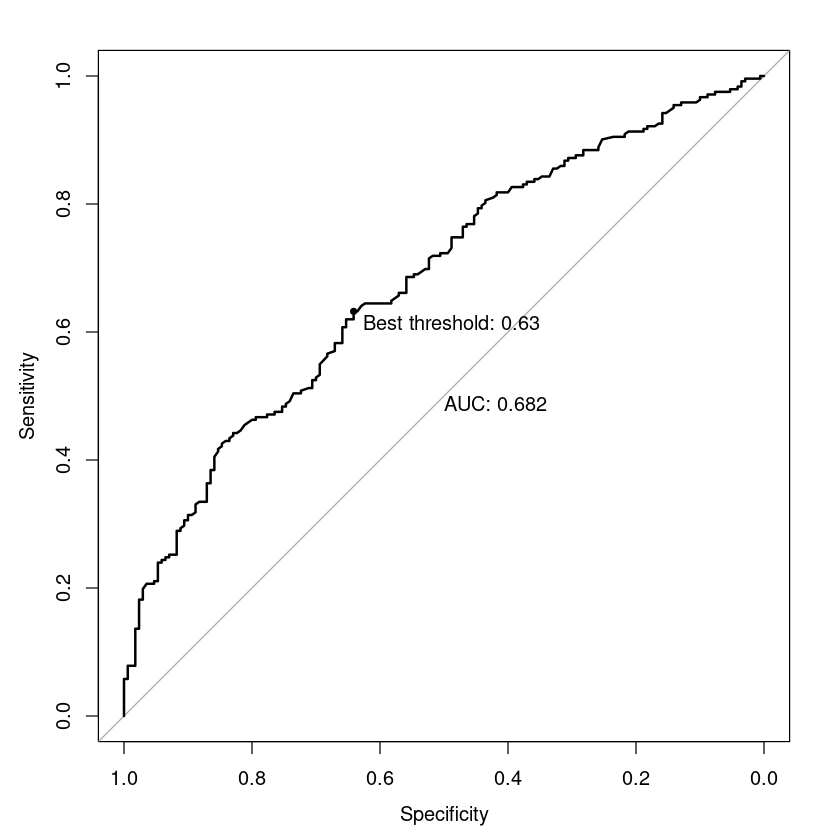

In [13]:
roc = roc(testdata$usesinternet ~ y_pred, plot=T, print.auc=T, 
          print.thres="best", print.thres.pattern="Best threshold: %1.2f")

In [14]:
myclassifier = train(x = X_train, y = y_train, method = 'glm', family='binomial', metric='Accuracy',
                     trControl = trainControl(method = "cv", number = 5, returnResamp ='all', savePredictions = TRUE),)
print(myclassifier$resample)
print(myclassifier$results)

   Accuracy     Kappa parameter Resample
1 0.6646526 0.2376911      none    Fold1
2 0.6042296 0.0767380      none    Fold2
3 0.6283988 0.1552794      none    Fold3
4 0.6636364 0.2225901      none    Fold4
5 0.6484848 0.1889143      none    Fold5
  parameter  Accuracy     Kappa AccuracySD    KappaSD
1      none 0.6418804 0.1762426 0.02566539 0.06408044


In [15]:
#tunegrid <- expand.grid(.mtry=c(1,10), number = c(10,50,100)) 

#tunegrid <- expand.grid(.mtry = (1:15)) 
tunegrid <- expand.grid(.mtry=c(2), .number = c(10, 50, 100)) 


train_control = trainControl(method = "cv", number = 5)

rf_gridsearch =   train(x = X_train, y = y_train, method = "rf",
                       metric = 'Accuracy',  trControl = train_control, 
                       tuneGrid = tunegrid)
print(rf_gridsearch)



ERROR: Error: The tuning parameter grid should have columns mtry


In [ ]:
tunegrid <- expand.grid(.mtry=c(2), .number = c(10, 50, 100)) 
tunegrid

In [ ]:
# Create the grid of parameters
grid <- expand.grid(Loss=c('L1','L2'),
                   cost=c(100,1000))

# Train the model using our previously defined parameters
gridsearch = train(x = X_train, y = y_train,  preProcess = c("center", "scale"), 
                 method = "svmLinear3",
                 trControl = trainControl(method = "cv", number = 5),
                 tuneGrid = grid)
gridsearch